In [1]:
import pandas as pd

# Load the saved CSV file
data = pd.read_csv('processed_data.csv')


In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import torch
from torch.utils.data import Dataset, DataLoader

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Define target and input variables
target_cols = ['meanLineIntensity', 'meanNumPixels15']
input_cols = ['Z', 'd_edge_left', 'd_edge_right', 'NoLines', 'd_over_left'] 

# Extract features and targets
X = data[input_cols].values
y = data[target_cols].values

# Create a custom Dataset class
class CustomDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.FloatTensor(X)
        self.y = torch.FloatTensor(y)
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Function to prepare data loaders for a specific fold
def prepare_fold_data(X, y, train_idx, val_idx, batch_size=32):
    # StandardScaler for features
    scaler = StandardScaler()
    scaler_y = StandardScaler()  
    
    # Scale features
    X_train = scaler.fit_transform(X[train_idx])
    X_val = scaler.transform(X[val_idx])
    
    # Scale targets
    y_train = scaler_y.fit_transform(y[train_idx])
    y_val = scaler_y.transform(y[val_idx])
    
    # Create datasets
    train_dataset = CustomDataset(X_train, y_train)
    val_dataset = CustomDataset(X_val, y_val)
    
    # Create data loaders 
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True
    )
    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False
    )
    
    return train_loader, val_loader, scaler, scaler_y

# Set up K-Fold cross-validation
n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

# Store fold indices for later use
fold_indices = []
for train_idx, val_idx in kf.split(X):
    fold_indices.append((train_idx, val_idx))


In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.multioutput import MultiOutputRegressor
from typing import Dict, List, Tuple

def create_model(name):
    """Helper function to create a new model instance"""
    if name == 'Linear Regression':
        return LinearRegression()
    elif name == 'Ridge':
        return Ridge(alpha=1.0)
    elif name == 'Lasso':
        return Lasso(alpha=1.0)
    elif name == 'ElasticNet':
        return ElasticNet(alpha=1.0, l1_ratio=0.5)
    elif name == 'Random Forest':
        return RandomForestRegressor(n_estimators=100, random_state=42)
    elif name == 'Gradient Boosting':
        return GradientBoostingRegressor(n_estimators=100, random_state=42, learning_rate=0.1)
    elif name == 'SVR':
        return SVR(kernel='rbf', C=1.0)

def evaluate_regressors(X: np.ndarray, 
                       y: np.ndarray, 
                       fold_indices: List[Tuple], 
                       target_names: List[str] = None,
                       scale: bool = True) -> Dict:
    """
    Evaluate multiple regression models using k-fold cross-validation.
    Handles both single-output and multi-output regression.
    """
    if target_names is None:
        target_names = [f'Target {i+1}' for i in range(y.shape[1])]
    
    # List of model names
    model_names = [
        'Linear Regression',
        'Ridge',
        'Lasso',
        'ElasticNet',
        'Random Forest',
        'Gradient Boosting',
        'SVR'
    ]
    
    # Initialize results dictionary
    results = {name: {
        'mse': [], 
        'r2': [],
        'predictions': [],
        'actuals': [],
        'trained_model': None,
        'scaler': None,
        'scaler_y': None
    } for name in model_names}
    
    # Perform k-fold cross-validation
    for fold_no, indices in enumerate(fold_indices):
        print(f'\nFold: {fold_no + 1}')
        print('-' * 50)
        
        X_train, X_val = X[indices[0]], X[indices[1]]
        y_train, y_val = y[indices[0]], y[indices[1]]
        
        # Initialize new scalers for each fold
        scaler = StandardScaler()
        scaler_y = StandardScaler()
        
        # Scale features if requested
        if scale:
            X_train = scaler.fit_transform(X_train)
            y_train = scaler_y.fit_transform(y_train)
            X_val = scaler.transform(X_val)
            y_val = scaler_y.transform(y_val)
        
        # Evaluate each model
        for name in model_names:
            try:
                # Create a fresh instance of the base model
                base_model = create_model(name)
                
                # Wrap in MultiOutputRegressor if needed
                is_multioutput = len(y.shape) > 1 and y.shape[1] > 1
                if is_multioutput and not hasattr(base_model, 'multi_output_'):
                    model = MultiOutputRegressor(base_model)
                else:
                    model = base_model
                
                # Fit and predict
                model.fit(X_train, y_train)
                y_pred = model.predict(X_val)
                
                # Calculate metrics
                mse = mean_squared_error(y_val, y_pred)
                r2 = r2_score(y_val, y_pred, multioutput='raw_values')
                
                # Store results
                results[name]['mse'].append(mse)
                results[name]['r2'].append(r2)
                results[name]['predictions'].append(y_pred)
                results[name]['actuals'].append(y_val)
                
                # Store model and scalers from last fold
                if fold_no == len(fold_indices) - 1:
                    results[name]['trained_model'] = model
                    if scale:
                        results[name]['scaler'] = scaler
                        results[name]['scaler_y'] = scaler_y
                
                print(f'{name}:')
                print(f'  MSE: {mse:.4f}')
                print(f'  R² scores: {r2}')
                
            except Exception as e:
                print(f'Error with {name}: {str(e)}')
                continue
    
    # Calculate and print mean scores
    print('\nCross-validation Mean Scores:')
    print('-' * 50)
    best_model = None
    best_mse = float('inf')
    
    for name in model_names:
        if results[name]['mse']:  # Check if model was successfully evaluated
            mean_mse = np.mean(results[name]['mse'])
            mean_r2 = np.mean(results[name]['r2'], axis=0)
            
            # Store mean scores in results
            results[name]['mean_mse'] = mean_mse
            results[name]['mean_r2'] = mean_r2
            
            print(f'{name}:')
            print(f'  Mean MSE: {mean_mse:.4f}')
            print(f'  Mean R²: {mean_r2}')
            
            # Track best model
            if mean_mse < best_mse:
                best_mse = mean_mse
                best_model = name
    
    # Plot results for best model
    if best_model:
        print(f"\nVisualizing results for best model: {best_model}")
        
        # Concatenate predictions and actuals from all folds
        predictions = np.concatenate(results[best_model]['predictions'], axis=0)
        actuals = np.concatenate(results[best_model]['actuals'], axis=0)
        r2_scores = results[best_model]['mean_r2']
        
        # Create subplots for each target
        fig, axes = plt.subplots(1, len(target_names), figsize=(6*len(target_names), 5))
        if len(target_names) == 1:
            axes = [axes]
            
        for i, (ax, target) in enumerate(zip(axes, target_names)):
            # Plot predicted vs actual
            ax.scatter(actuals[:, i], predictions[:, i], alpha=0.5)
            # Plot perfect prediction line
            min_val = min(actuals[:, i].min(), predictions[:, i].min())
            max_val = max(actuals[:, i].max(), predictions[:, i].max())
            ax.plot([min_val, max_val], [min_val, max_val], 'r--', label='Perfect Prediction')
            # Add labels and title
            ax.set_xlabel('Actual Values (Standardized)')
            ax.set_ylabel('Predicted Values (Standardized)')
            ax.set_title(f'{target}\nR² = {r2_scores[i]:.4f}')
            ax.grid(True)
            ax.legend()
        
        plt.tight_layout()
        plt.show()
    
    return results


Fold: 1
--------------------------------------------------
Linear Regression:
  MSE: 0.5384
  R² scores: [0.50493267 0.31038152]
Ridge:
  MSE: 0.5384
  R² scores: [0.50496848 0.31039701]
Lasso:
  MSE: 0.9077
  R² scores: [-0.00865646 -0.00498049]
ElasticNet:
  MSE: 0.8867
  R² scores: [ 0.04022073 -0.00498049]
Random Forest:
  MSE: 0.1503
  R² scores: [0.8547451  0.81394809]
Gradient Boosting:
  MSE: 0.1899
  R² scores: [0.80741598 0.77304635]
SVR:
  MSE: 0.4164
  R² scores: [0.59882874 0.48327935]

Fold: 2
--------------------------------------------------
Linear Regression:
  MSE: 0.5764
  R² scores: [0.46052306 0.2421029 ]
Ridge:
  MSE: 0.5763
  R² scores: [0.46067706 0.24218076]
Lasso:
  MSE: 0.8903
  R² scores: [-0.00709351 -0.00278385]
ElasticNet:
  MSE: 0.8704
  R² scores: [ 0.03862273 -0.00278385]
Random Forest:
  MSE: 0.1688
  R² scores: [0.83712153 0.78283688]
Gradient Boosting:
  MSE: 0.2067
  R² scores: [0.78681184 0.74728879]
SVR:
  MSE: 0.4553
  R² scores: [0.56343255 0.

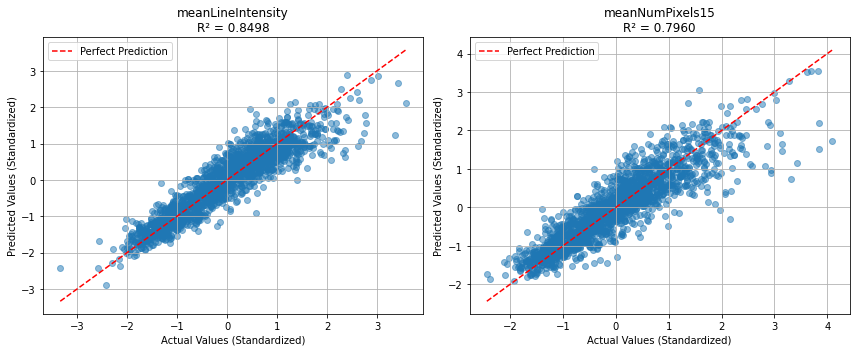

In [5]:
results = evaluate_regressors(X, y, fold_indices, target_names=target_cols, scale=True)

# Get the best model name and its results
best_model_name = min(results.items(), key=lambda x: x[1]['mean_mse'] if x[1]['mse'] else float('inf'))[0]
best_model_results = results[best_model_name]

# Access the trained model and scalers
trained_model = best_model_results['trained_model']
scaler = best_model_results['scaler']
scaler_y = best_model_results['scaler_y']

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def analyze_subsample(data, target_cols, input_cols):
    """
    Analyze and visualize subsample of data where Z ≤ 0.5
    
    Args:
        data: DataFrame containing the data
        target_cols: List of target column names
        input_cols: List of input column names
    """
    # Create subsample
    subsample = data[data['Z'] <= 0.5].copy()
    print(f"Original data size: {len(data)}")
    print(f"Subsample size (Z ≤ 0.5): {len(subsample)}")
    
    # Calculate medians for target columns
    print("\nMedian values for target columns in subsample:")
    for col in target_cols:
        median = subsample[col].median()
        print(f"{col}: {median:.4f}")
    
    # Create figure for visualization plots
    fig = plt.figure(figsize=(15, 10))
    
    # 1. Scatter plot of Z vs NoLines (colored by first target)
    ax1 = fig.add_subplot(221)
    scatter = ax1.scatter(subsample['NoLines'], subsample['Z'], 
                         alpha=0.5, c=subsample[target_cols[0]], cmap='viridis')
    ax1.set_xlabel('NoLines')
    ax1.set_ylabel('Z')
    ax1.set_title('Z vs NoLines (colored by meanLineIntensity)')
    plt.colorbar(scatter, ax=ax1, label=target_cols[0])
    
    # 2. Histogram for first target
    ax2 = fig.add_subplot(222)
    sns.histplot(data=subsample, x=target_cols[0], bins=30, ax=ax2)
    ax2.axvline(subsample[target_cols[0]].median(), color='r', linestyle='--', 
                label=f'Median: {subsample[target_cols[0]].median():.2f}')
    ax2.set_title(f'Distribution of {target_cols[0]}')
    ax2.legend()
    
    # 3. Scatter plot of Z vs NoLines (colored by second target)
    ax3 = fig.add_subplot(223)
    scatter2 = ax3.scatter(subsample['NoLines'], subsample['Z'], 
                          alpha=0.5, c=subsample[target_cols[1]], cmap='viridis')
    ax3.set_xlabel('NoLines')
    ax3.set_ylabel('Z')
    ax3.set_title('Z vs NoLines (colored by meanNumPixels15)')
    plt.colorbar(scatter2, ax=ax3, label=target_cols[1])
    
    # 4. Histogram for second target
    ax4 = fig.add_subplot(224)
    sns.histplot(data=subsample, x=target_cols[1], bins=30, ax=ax4)
    ax4.axvline(subsample[target_cols[1]].median(), color='r', linestyle='--', 
                label=f'Median: {subsample[target_cols[1]].median():.2f}')
    ax4.set_title(f'Distribution of {target_cols[1]}')
    ax4.legend()
    
    plt.tight_layout()
    plt.show()
    
    # Create correlation matrix
    corr_vars = target_cols + ['Z', 'NoLines']
    corr_matrix = subsample[corr_vars].corr()
    
    # Plot correlation heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(corr_matrix, 
                annot=True,  # Show correlation values
                cmap='RdBu',  # Red-Blue colormap
                vmin=-1, vmax=1,  # Set limits for correlation values
                center=0,  # Center the colormap at 0
                fmt='.2f')  # Format correlation values to 2 decimal places
    plt.title('Correlation Matrix Heatmap')
    plt.tight_layout()
    plt.show()
    
    # Print descriptive statistics
    print("\nDescriptive statistics for subsample:")
    print(subsample[corr_vars].describe())
    
    return subsample


Original data size: 1812
Subsample size (Z ≤ 0.5): 536

Median values for target columns in subsample:
meanLineIntensity: 1820438.1124
meanNumPixels15: 5309.2697


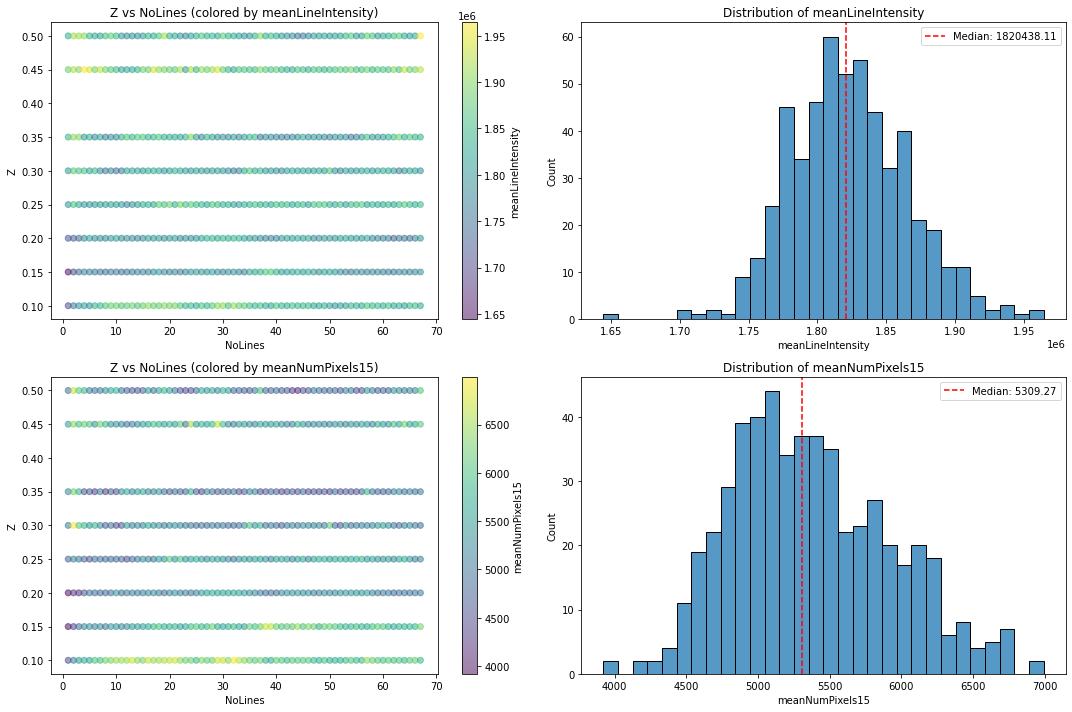

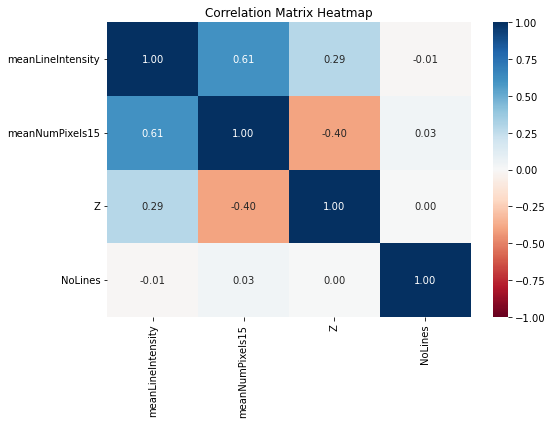


Descriptive statistics for subsample:
       meanLineIntensity  meanNumPixels15           Z     NoLines
count       5.360000e+02       536.000000  536.000000  536.000000
mean        1.823423e+06      5370.828736    0.287500   34.000000
std         4.282066e+04       555.551258    0.131819   19.357145
min         1.644354e+06      3920.247191    0.100000    1.000000
25%         1.794454e+06      4966.901685    0.187500   17.000000
50%         1.820438e+06      5309.269663    0.275000   34.000000
75%         1.850996e+06      5762.862360    0.375000   51.000000
max         1.964377e+06      6992.033708    0.500000   67.000000


In [7]:
subsample = analyze_subsample(data, target_cols, input_cols)


In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import seaborn as sns
from tqdm import tqdm

def optimize_feature(model_results, data, input_cols, target_cols, feature_to_optimize):
    """
    Optimize a selected input feature to minimize distance to target medians.
    
    Args:
        model_results: Dictionary containing trained model and scalers from evaluate_regressors
        data: Full dataset
        input_cols: List of input column names
        target_cols: List of target column names
        feature_to_optimize: Name of the feature to optimize
    """
    # Extract model and scalers
    model = model_results['trained_model']
    scaler = model_results['scaler']
    scaler_y = model_results['scaler_y']
    
    # Get subsample and compute target medians
    subsample = data[data['Z'] <= 0.5]
    subsample_scaled = scaler_y.transform(subsample[target_cols])
    subsample_medians = np.median(subsample_scaled, axis=0)
    
    W_star, l_star = subsample_medians
    print(f"Target medians (scaled): {target_cols[0]}={W_star:.4f}, {target_cols[1]}={l_star:.4f}")
    
    # Index of feature to optimize in input_cols
    feature_idx = input_cols.index(feature_to_optimize)
    
    def objective_function(P, x_original_scaled):
        """
        Compute Euclidean distance between model predictions and target medians.
        
        Args:
            P: Value of feature being optimized (in scaled space)
            x_original_scaled: Original input values (in scaled space)
        """
        # Create input array with modified feature value
        x_modified = x_original_scaled.copy()
        x_modified[feature_idx] = P
        
        # Get model predictions
        pred = model.predict(x_modified.reshape(1, -1))[0]
        
        # Compute Euclidean distance to target medians
        distance = np.sqrt(np.sum((pred - [W_star, l_star])**2))
        return distance
    
    # Store results
    results = []
    
    # Optimize for each sample in dataset
    print(f"Optimizing {feature_to_optimize} for each sample...")
    
    # Scale full input data
    X_scaled = scaler.transform(data[input_cols])
    
    for idx in tqdm(range(len(data))):
        # Skip samples in subsample (Z <= 0.5)
        if data['Z'].iloc[idx] <= 0.5:
            continue
        
        x_original_scaled = X_scaled[idx]
        
        # Optimize feature value
        initial_guess = x_original_scaled[feature_idx]
        opt_result = minimize(objective_function, 
                            x0=initial_guess,
                            args=(x_original_scaled,),
                            method='Nelder-Mead')
        
        # Get predictions with original and optimal feature value
        x_modified = x_original_scaled.copy()
        x_modified[feature_idx] = opt_result.x[0]
        
        # Get predictions in original scale
        original_pred = scaler_y.inverse_transform(
            model.predict(x_original_scaled.reshape(1, -1)))[0]
        optimal_pred = scaler_y.inverse_transform(
            model.predict(x_modified.reshape(1, -1)))[0]
        
        # Transform optimal value back to original scale
        X_temp = X_scaled.copy()
        X_temp[idx, feature_idx] = opt_result.x[0]
        optimal_value_original = scaler.inverse_transform(X_temp)[idx, feature_idx]
        
        results.append({
            'sample_idx': idx,
            'original_value': data[feature_to_optimize].iloc[idx],
            'optimal_value': optimal_value_original,
            'original_distance': objective_function(initial_guess, x_original_scaled),
            'optimal_distance': opt_result.fun,
            'original_pred_W': original_pred[0],
            'original_pred_l': original_pred[1],
            'optimal_pred_W': optimal_pred[0],
            'optimal_pred_l': optimal_pred[1],
            'convergence': opt_result.success
        })
    
    results_df = pd.DataFrame(results)
    
    # Visualization
    plot_optimization_results(results_df, feature_to_optimize, 
                            scaler_y.inverse_transform([subsample_medians])[0], 
                            target_cols)
    
    return results_df

def plot_optimization_results(results_df, feature_name, target_medians, target_cols):
    """Create visualizations of optimization results."""
    fig = plt.figure(figsize=(15, 10))
    
    # 1. Original vs Optimal feature values
    ax1 = fig.add_subplot(221)
    ax1.scatter(results_df['original_value'], results_df['optimal_value'], alpha=0.5)
    min_val = min(results_df['original_value'].min(), results_df['optimal_value'].min())
    max_val = max(results_df['original_value'].max(), results_df['optimal_value'].max())
    ax1.plot([min_val, max_val], [min_val, max_val], 'r--', label='y=x')
    ax1.set_xlabel(f'Original {feature_name}')
    ax1.set_ylabel(f'Optimal {feature_name}')
    ax1.set_title('Original vs Optimal Feature Values')
    ax1.legend()
    
    # 2. Distribution of optimal values
    ax2 = fig.add_subplot(222)
    sns.histplot(data=results_df, x='optimal_value', bins=30, ax=ax2)
    ax2.axvline(results_df['optimal_value'].median(), color='r', linestyle='--',
                label=f'Median: {results_df["optimal_value"].median():.2f}')
    ax2.set_xlabel(f'Optimal {feature_name}')
    ax2.set_title('Distribution of Optimal Values')
    ax2.legend()
    
    # 3. Original vs Optimal distances
    ax3 = fig.add_subplot(223)
    ax3.scatter(results_df['original_distance'], results_df['optimal_distance'], alpha=0.5)
    min_val = min(results_df['original_distance'].min(), results_df['optimal_distance'].min())
    max_val = max(results_df['original_distance'].max(), results_df['optimal_distance'].max())
    ax3.plot([min_val, max_val], [min_val, max_val], 'r--', label='y=x')
    ax3.set_xlabel('Original Distance to Target')
    ax3.set_ylabel('Optimal Distance to Target')
    ax3.set_title('Original vs Optimal Distances')
    ax3.legend()
    
    # 4. Prediction improvement
    ax4 = fig.add_subplot(224)
    improvement = results_df['original_distance'] - results_df['optimal_distance']
    sns.histplot(data=improvement, bins=30, ax=ax4)
    ax4.axvline(improvement.median(), color='r', linestyle='--',
                label=f'Median: {improvement.median():.2f}')
    ax4.set_xlabel('Distance Improvement')
    ax4.set_title('Distribution of Optimization Improvement')
    ax4.legend()
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print("\nOptimization Summary:")
    print(f"Median distance improvement: {improvement.median():.4f}")
    print(f"Mean distance improvement: {improvement.mean():.4f}")
    print(f"Optimization convergence rate: {(results_df['convergence'].mean()*100):.1f}%")



Target medians (scaled): meanLineIntensity=-1.1912, meanNumPixels15=-0.9274
Optimizing d_edge_left for each sample...


100%|███████████████████████████████████████| 1812/1812 [04:08<00:00,  7.29it/s]


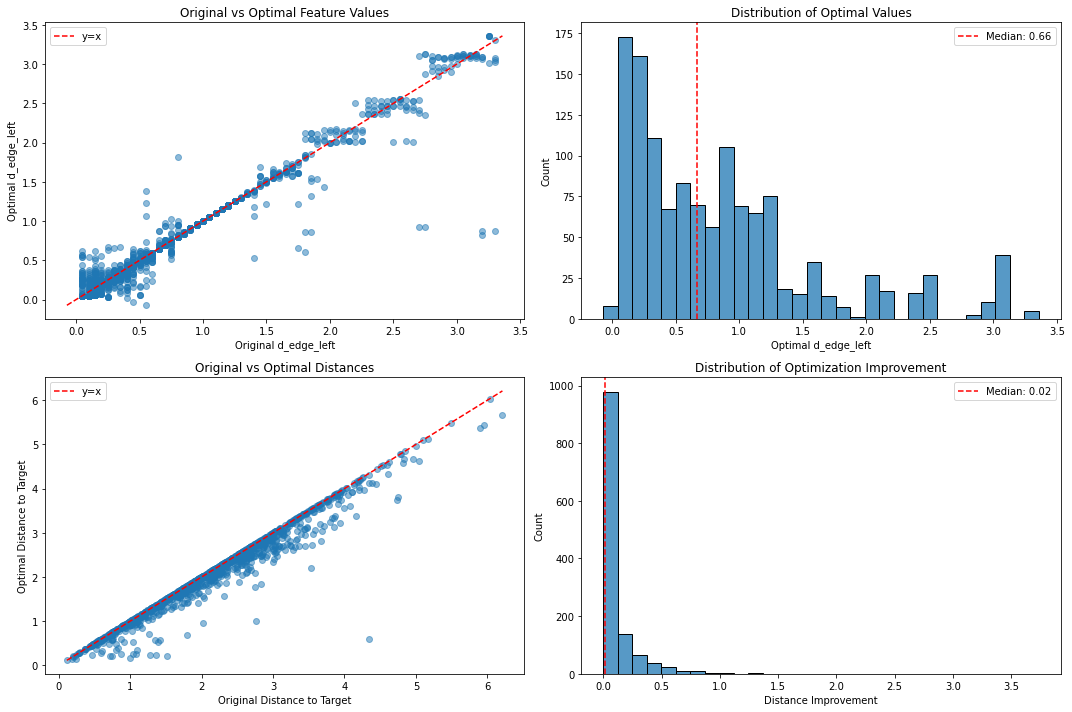


Optimization Summary:
Median distance improvement: 0.0154
Mean distance improvement: 0.0988
Optimization convergence rate: 100.0%


In [10]:
# After running evaluate_regressors:
best_model_name = min(results.items(), key=lambda x: x[1]['mean_mse'] if x[1]['mse'] else float('inf'))[0]
best_model_results = results[best_model_name]

# Run optimization
results_df = optimize_feature(best_model_results, data, input_cols, target_cols, 
                            feature_to_optimize='d_edge_left')
